In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Labels info:
- Label 1: Necrotic and non-enhancing tumor core
- Label 2: peritumoral edema (ED)
- Label 3: Missing
- Label 4: GD-enhancing Tumor

Unzip the dataset

In [2]:
import os
import zipfile


# Define the path to the zip file:
zip_file_path = "/content/drive/MyDrive/Glioma_Segmentation/dataset.zip"

# Destination folder
destination_folder = "/content/dataset"
# Open the zip file:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file to the current directory:
    zip_ref.extractall(destination_folder)
    print("Done")

Done


In [3]:
!python -c "import matplotlib" || pip install -q matplotlib
!pip install tempfile
!pip install split-folders
!pip install torchvision
!pip install torchmetrics

%matplotlib inline

ERROR: Could not find a version that satisfies the requirement tempfile (from versions: none)
ERROR: No matching distribution found for tempfile
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (1

Import directory and Folder


In [4]:
import os
import glob
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import random
import tempfile
import nibabel as nib
import shutil
from typing import List, Dict
from typing import List, Dict, Union, Sequence, Callable
import sys
import splitfolders
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import torch.nn.functional as F
import shutil

[0. 1. 2. 4.]
[0. 1. 2. 3.]
(240, 240, 155)


Text(0.5, 1.0, 'Mask')

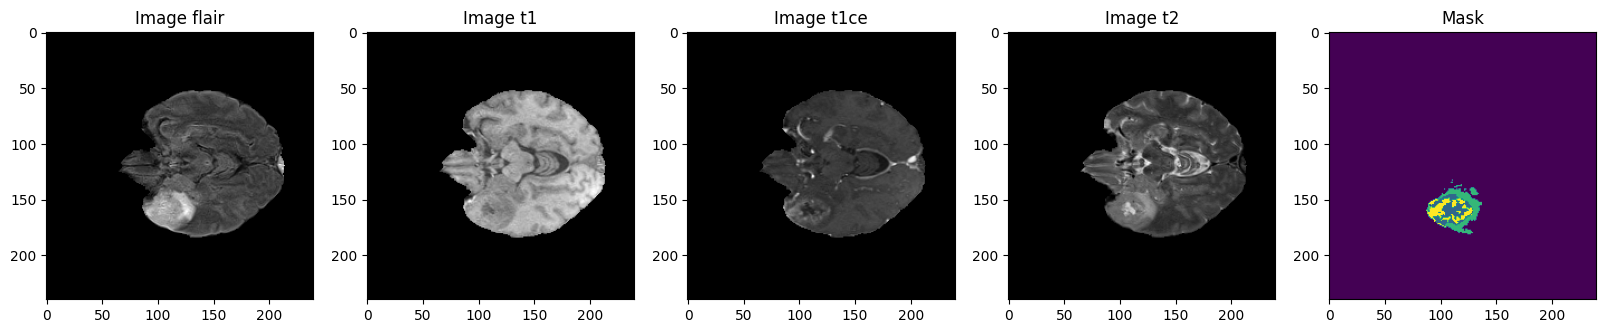

In [5]:
TRAIN_DATASET_PATH = "/content/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_019/BraTS20_Training_019_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_019/BraTS20_Training_019_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_019/BraTS20_Training_019_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_019/BraTS20_Training_019_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_019/BraTS20_Training_019_seg.nii').get_fdata()

print(np.unique(test_mask))
test_mask[test_mask == 4] = 3
print(np.unique(test_mask))

print(test_mask.shape)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 60
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')


#folder_path = '/content/dataset/input_data_3channels/'
#shutil.rmtree(folder_path)


In [ ]:
import os
import glob
import numpy as np
import nibabel as nib
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

def load_and_normalize(modality_path):
    """Load and normalize an MRI scan using StandardScaler."""
    image = nib.load(modality_path).get_fdata()
    scaler = StandardScaler()
    image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
    return image

def process_volume(t2_path, t1ce_path, flair_path, mask_path, output_img_dir, output_mask_dir, index):
    """Process each volume and save as numpy arrays if they meet criteria."""
    temp_image_t2 = load_and_normalize(t2_path)
    temp_image_t1ce = load_and_normalize(t1ce_path)
    temp_image_flair = load_and_normalize(flair_path)
    temp_mask = nib.load(mask_path).get_fdata().astype(np.uint8)
    temp_mask[temp_mask == 4] = 3  # Reassign mask values

    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    val, counts = np.unique(temp_mask, return_counts=True)

    if (1 - (counts[0]/counts.sum())) > 0.01:  # At least 1% useful volume
        print(f"Save image and mask number: {index}")
        mask_one_hot = to_categorical(temp_mask, num_classes=4)
        np.save(os.path.join(output_img_dir, f'image_{index}.npy'), temp_combined_images)
        np.save(os.path.join(output_mask_dir, f'mask_{index}.npy'), mask_one_hot)
    else:
        print(f"Skipping image and mask number: {index}, insufficient useful volume.")

def create_directories(base_path):
    """Create directories for storing processed images and masks."""
    image_dir = os.path.join(base_path, 'images')
    mask_dir = os.path.join(base_path, 'masks')
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)
    return image_dir, mask_dir

def main_processing(input_dir, output_dir):
    # Set up file paths and directories
    modalities = ['t2', 't1ce', 'flair', 'seg']
    file_lists = {modality: sorted(glob.glob(os.path.join(input_dir, f'*/*{modality}.nii'))) for modality in modalities}
    output_img_dir, output_mask_dir = create_directories(output_dir)

    # Process each volume
    for idx in range(len(file_lists['t2'])):
        print(f"Now preparing image and masks number: {idx}")
        process_volume(file_lists['t2'][idx], file_lists['t1ce'][idx], file_lists['flair'][idx], file_lists['seg'][idx],
                       output_img_dir, output_mask_dir, idx)

# Example usage
input_dir_train = '/content/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
output_dir_train = '/content/dataset/input_data_3channels'
main_processing(input_dir_train, output_dir_train)



In [8]:
import splitfolders  # or import split_folders

input_folder = '/content/dataset/input_data_3channels/'
output_folder = '/content/dataset/input_data_128/'
# Split with a ratio.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.80, .10, .10), group_prefix=None)

Copying files: 688 files [01:44,  6.59 files/s]


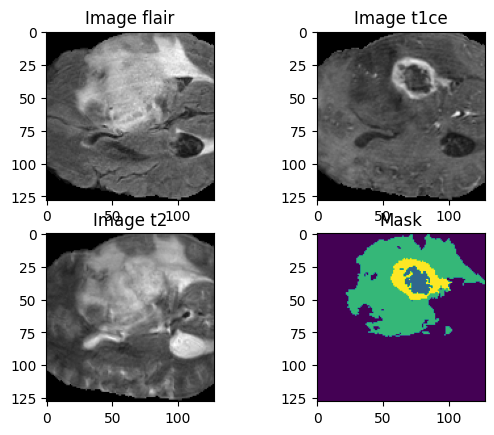

In [73]:
image = np.load('/content/dataset/input_data_128/train/images/image_0.npy')
mask = np.load('/content/dataset/input_data_128/train/masks/mask_0.npy')


image = torch.tensor(image, dtype=torch.float32)
mask = torch.tensor(mask, dtype=torch.float32)
image = image.permute(3, 0, 1, 2)
mask = mask.permute(3, 0, 1, 2)
mask = torch.argmax(mask, dim = 0)

plt.subplot(221)
plt.imshow(image[0,:,:,60], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(image[1,:,:,60], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(image[2,:,:,60], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(mask[:,:,60], cmap='viridis')
plt.title('Mask')
plt.show()

In [9]:
class MyDataset(Dataset):
  def __init__(self, files, transform = None):
    self.files = files
    self.transform = transform

  def get_files(self):
    return self.files

  def __len__(self):
    return len(self.get_files())

  def __getitem__(self, idx):
    image_path = self.get_files()[idx]['image']
    mask_path = self.get_files()[idx]['label']

    # Load the image and mask using nibabel
    image = np.load(image_path)
    mask = np.load(mask_path)

    # Convert the numpy arrays into PyTorch tensors
    image = torch.tensor(image, dtype=torch.float32)
    mask = torch.tensor(mask, dtype=torch.float32)
    image = image.permute(3, 0, 1, 2)
    mask = mask.permute(3, 0, 1, 2)
    sample = {'image': image, 'label': mask}


    if self.transform:
      sample = self.transform(sample)
    return sample
import shutil


**Imnplement Data Augmentation**

In [12]:
class RandomFlip:
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        axes = [1, 2, 3]  # Corresponding to spatial dimensions

        for axis in axes:
            if random.random() > 0.5:
                image = torch.flip(image, [axis])
                label = torch.flip(label, [axis])

        return {'image': image, 'label': label}

class RandomRotate90:
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        k = random.randint(0, 3)  # Number of 90-degree rotations
        axes = (2, 3)  # Axes around which to rotate the image and label

        image = torch.rot90(image, k, axes)
        label = torch.rot90(label, k, axes)

        return {'image': image, 'label': label}

class RandomIntensityScale:
  def __call__(self, sample):
    image = sample['image']
    label = sample['label']

    factor = random.uniform(0.9, 1.1)
    image = image * factor
    return {'image': image, 'label': label}


class RandomIntensityShift:
  def __call__(self, sample):
    image = sample['image']
    label = sample['label']

    shift = random.uniform(-1.1, 1.1)

    image = image + shift
    return {'image': image, 'label': label}


train_transform = transforms.Compose(
    [
      #RandomFlip(),
      #RandomRotate90(),
      #RandomIntensityScale(),
      #RandomIntensityShift()
    ]
)

val_transform = None
test_transform = None

**Set up transform for training and validation set**

Documentation of each line:
- EnsureChannelFirstd: Ensure the channel dimension is the first dimension of the input data
- EnsureTyped: Ensure the input type is either in Tensor or numpy array
- Orientationd: Adjust the the image to the desired orientation
- Spacingd: Handles volumetric pixel (voxel)_in the data. Usually in mm
- RandSpatialCropd: Crop the image randomly
- RandFlipd: Flip the image with probability in a axes x, y, z
- NormalizeIntensity: Standardize the intensity of non-zero pixel and by channels. Using z-score normalization
- RandScaleIntensity: Ramdomly Scaling Intensity by v =

** Set up the directory and the dataset **

In [20]:
import glob
import os
from torch.utils.data import DataLoader
root_dir_train = '/content/dataset/input_data_128/train'
root_dir_val = '/content/dataset/input_data_128/val'
root_dir_test = '/content/dataset/input_data_128/test'

train_images_path = sorted(glob.glob(os.path.join(root_dir_train, 'images', '*.npy')))
train_labels_path = sorted(glob.glob(os.path.join(root_dir_train, 'masks', '*.npy')))

val_images_path = sorted(glob.glob(os.path.join(root_dir_val, 'images', '*.npy')))
val_labels_path = sorted(glob.glob(os.path.join(root_dir_val, 'masks', '*.npy')))

test_images_path = sorted(glob.glob(os.path.join(root_dir_test, 'images', '*.npy')))
test_labels_path = sorted(glob.glob(os.path.join(root_dir_test, 'masks', '*.npy')))


train_files_path = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(train_images_path, train_labels_path)]
val_files_path = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(val_images_path, val_labels_path)]
test_files_path = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(test_images_path, test_labels_path)]

train_dataset = MyDataset(train_files_path, transform = train_transform)
val_dataset = MyDataset(val_files_path, transform = val_transform)
test_dataset = MyDataset(test_files_path, transform = test_transform)

train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = True, num_workers = 4)
val_loader = DataLoader(val_dataset, batch_size = 1, shuffle = False, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, num_workers = 4)


**Check the dataset by visualizing and plotting**

image shape: torch.Size([3, 128, 128, 128])


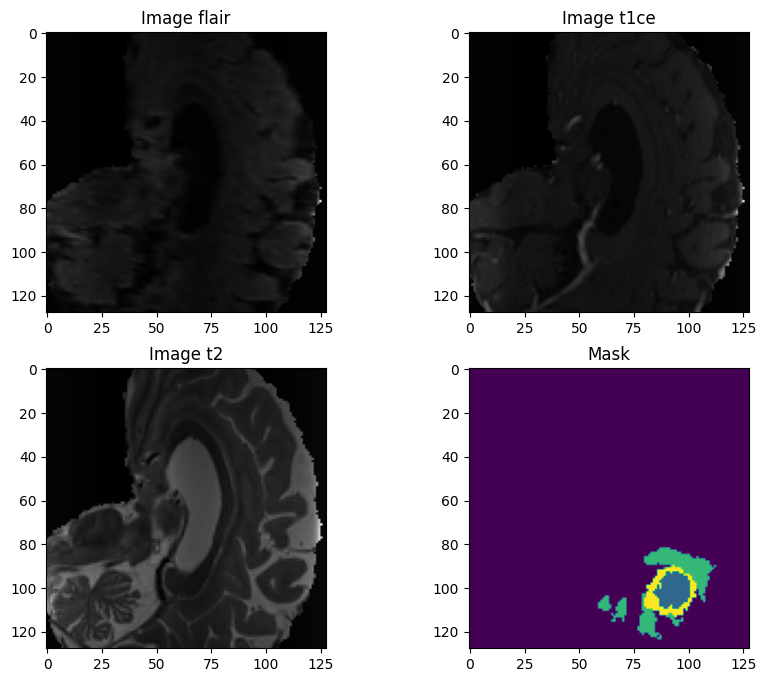

In [84]:
import matplotlib.pyplot as plt

# Assuming combined_x and mask tensors are correctly shaped as [C, D, H, W]
n_slice = 60  # This should be within the 'Depth' dimension
combined_x = train_dataset[255]['image']
print("image shape:", combined_x.shape)
mask  = train_dataset[255]['label']
test_mask_argmax = torch.argmax(mask, dim = 0)
# Display the image slices
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.imshow(combined_x[0, n_slice, :, :], cmap='gray')  # Channel 0 at slice 'n_slice'
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[1, n_slice, :, :], cmap='gray')  # Channel 1 at slice 'n_slice'
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[2, n_slice, :, :], cmap='gray')  # Channel 2 at slice 'n_slice'
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask_argmax[:, :, n_slice], cmap = 'viridis')
plt.title('Mask')
plt.show()



**Set up 3DUnet Architecture**


In [27]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels, mid_channels = None, dropout = 0.1):
    super(DoubleConv, self).__init__()
    if not mid_channels:
      mid_channels = out_channels
    self.double_conv = nn.Sequential(
        nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding = 1),
        nn.BatchNorm3d(mid_channels),
        nn.ReLU(inplace = True),
        nn.Dropout3d(dropout),

        nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding = 1),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace = True),
        nn.Dropout3d(dropout)
    )

  def forward(self, x):
    return self.double_conv(x)

class Down(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Down, self).__init__()
    self.maxpool_conv = nn.Sequential(
        nn.MaxPool3d(2),
        DoubleConv(in_channels, out_channels)
    )

  def forward(self, x):
    return self.maxpool_conv(x)


class Up(nn.Module):

  def __init__(self, in_channels, out_channels, bilinear = False):
    super(Up, self).__init__()

    if bilinear:
      self.up = nn.Upsample(scale_factor = 2, mode = 'trilinear', align_corners = True)
      self.conv = nn.DoubleConv(in_channels, out_channels, in_channels // 2)
    else:
      self.up = nn.ConvTranspose3d(in_channels, in_channels // 2, kernel_size = 2, stride = 2)
      self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)

    diffZ = x2.size()[2] - x1.size()[2]
    diffY = x2.size()[3] - x1.size()[3]
    diffX = x2.size()[4] - x1.size()[4]

    x1 = F.pad(x1, [
        diffX // 2, diffX - diffX // 2,
        diffY // 2, diffY - diffY // 2,
        diffZ // 2, diffZ - diffZ // 2
    ])

    x = torch.cat([x2, x1], dim = 1)

    return self.conv(x)

class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

  def forward(self, x):
    return self.conv(x)


class UNet3D(nn.Module):
  def __init__(self, n_channels, n_classes, bilinear = False):
    super(UNet3D, self).__init__()
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.bilinear = bilinear

    self.inc = DoubleConv(n_channels, 64)
    self.down1 = Down(64, 128)
    self.down2 = Down(128, 256)
    self.down3 = Down(256, 512)
    self.up1 = Up(512, 256, bilinear)
    self.up2 = Up(256, 128, bilinear)
    self.up3 = Up(128, 64, bilinear)

    self.outc = OutConv(in_channels = 64, out_channels = n_classes)

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)

    x = self.up1(x4, x3)
    x = self.up2(x, x2)
    x = self.up3(x, x1)

    logits = self.outc(x)

    return logits


**Evaluation Metrics**

In [26]:
import torch.nn.functional as f

class DiceLoss(nn.Module):
  def __init__(self):
    super(DiceLoss, self).__init__()


  def forward(self, y_true, y_pred):
    smooth = 1e-5
    y_pred = torch.softmax(y_pred, dim = 1) # Apply softmax to get probabilities

    y_pred = y_pred.flatten(start_dim = 2)
    y_true = y_true.flatten(start_dim = 2)

    intersection = (y_pred * y_true).sum(dim = 2)
    union = y_pred.sum(dim = 2) + y_true.sum(dim = 2)

    dice = (2 * intersection + smooth) / (union + smooth)

    # Apply weights
    dice_loss = 1 - dice
    dice_loss = dice_loss.mean()
    return dice_loss

class IoU(nn.Module):

  def __init__(self, num_classes):
    super(IoU, self).__init__()
    self.num_classes = num_classes

  def forward(self, y_true, y_pred):
    smooth = 1e-5
    y_pred = torch.softmax(y_pred, dim = 1) # Apply softmax to get the best probabilities
    y_pred_classes = torch.argmax(y_pred, dim = 1) # Shape = [batch_size, Depth, Height, Width]

    #If y_true is one-hot encoded, convert to class labels
    if y_true.dim() == 5:  # [batch_size, num_classes, depth, height, width]
      y_true = torch.argmax(y_true, dim=1)  # Convert one-hot to class labels: [batch_size, depth, height, width]

    iou_per_class = []
    for c in range(self.num_classes):
      pred_c = (y_pred_classes == c).float()
      true_c = (y_true == c).float()

      # Flatten the tensors:
      pred_c = pred_c.flatten(start_dim=1)  # Shape: (batch_size, depth * height * width)
      true_c = true_c.flatten(start_dim=1)  # Shape: (batch_size, depth * height * width)

      intersection = (pred_c * true_c).sum(dim=1)
      union = pred_c.sum(dim=1) + true_c.sum(dim=1) - intersection

      iou = (intersection + smooth) / (union + smooth)

      iou_per_class.append(iou.mean())


    mean_iou = torch.mean(torch.stack(iou_per_class))

    return mean_iou

In [28]:
# Test case:
# Model predictions
outputs = torch.randn(4, 3, 128, 128, 128)  # Batch size 4, 3 classes, 128x128x128 volume

# Ground truth labels (class indices)
targets = torch.randint(0, 3, (4, 128, 128, 128))  # Batch size 4, depth 128, height 128, width 128

# One-hot encode the ground truth
targets_one_hot = F.one_hot(targets, num_classes=3).permute(0, 4, 1, 2, 3)  # Shape: (4, 3, 128, 128, 128)

print(f"outputs shape is: {outputs.shape}")
print(f"targets shape is: {targets_one_hot.shape}")
# Weights for each class
weights = torch.tensor([0.25, 0.25, 0.25])  # Example weights for 3 classes

# Instantiate the metrics
iou_metric = IoU(num_classes=3)
weighted_dice_metric = DiceLoss()

# Calculate IoU and Weighted Dice Loss
iou_score = iou_metric(targets_one_hot, outputs)
dice_loss = weighted_dice_metric(targets_one_hot, outputs)

print(f"IoU Score: {iou_score.item()}")
print(f"Dice Loss: {dice_loss.item()}")

outputs shape is: torch.Size([4, 3, 128, 128, 128])
targets shape is: torch.Size([4, 3, 128, 128, 128])
IoU Score: 0.1999955028295517
Dice Loss: 0.6666681170463562


**Typical Training Loop**

In [29]:
def validation(model, device, val_loader, num_classes):
  """
    Validate the model on the validation dataset.
    Args:
    - model: The model to validate.
    - device: The device to run the validation on (CPU or GPU).
    - val_loader: DataLoader for the validation dataset.
    - num_classes: The number of classes in the segmentation task.

    Returns:
    - val_loss: The average validation loss.
    - mean_iou: The mean Intersection over Union (IoU) score across all classes.
  """
  model.eval()
  val_loss = 0.0
  all_ious = []

  IoU_metric = IoU(num_classes)

  with torch.no_grad():
    for val_data in val_loader:
      input_x, y_true = val_data['image'].to(device), val_data['label'].to(device)
      y_pred = model(input_x)
      loss = DiceLoss()(y_true, y_pred)
      val_loss += loss.item()

      iou_score = IoU_metric(y_true, y_pred)
      all_ious.append(iou_score)

    val_loss /= len(val_loader)

    mean_iou = sum(all_ious) / len(all_ious)

  return val_loss, mean_iou


def train_model(model, train_loader, val_loader, device, num_classes, num_epochs, root_dir):
  """
  Train the 3D Unet Model

  Args:
  - model: model to be trained
  - train_loader: DataLoader for the training dataset
  - val_loader: DataLoader for the validation dataset
  - device: The device to run the training on (GPU or CPU)
  - num_classes: Number of classes in the segmentation task
  - num_epochs: Number of epochs to train the model
  - root_dir: Directory to save the best model

  Returns:
  - None (Saves the best model to disk and plots training/validation metrics).
  """

  # Set up the device for the model to run on:
  model.to(device)

  # Set up optimizer and learning rate scheduler:
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001, weight_decay = 1e-4)
  scheduler = CosineAnnealingLR(optimizer, T_max = num_epochs)


  # Initialize lists to store IoU and loss for plotting: train_loss, val_loss, val_iou
  train_losses = []
  val_losses = []
  val_ious = []


  # Initialize variables to track the best validation loss and its corresponding epochs:
  best_val_loss = float('inf')
  best_epochs = 0
  best_model_weights = model.state_dict()
  early_stopping_patience = 10
  early_stopping_counter = 0

  ## Training loop
  for epoch in range(num_epochs):
    print(f'Epoch #{epoch + 1}')
    model.train() # Set model to training mode
    train_loss = 0.0

    # Iterate over the training data
    for batch_idx, data in enumerate(train_loader):
      # Forward Propagation
      input_x, targets = data['image'].to(device), data['label'].to(device)
      # Should be (batch_size, channels, depth, height, width)
      optimizer.zero_grad()
      outputs = model(input_x)
      # Compute Loss Function
      loss = DiceLoss()(targets, outputs)
      # Using loss function to update parameters:
      loss.backward()
      optimizer.step()
      # Accumulate the training loss:
      train_loss += loss.item()
      print(f'Batch {batch_idx+1}/{len(train_loader)}, Batch Train Loss: {loss.item():.4f}')

    # Compute the average training loss in an epoch:
    train_loss /= len(train_loader)

    ## Validation loop:
    val_loss, mean_iou = validation(model, device, val_loader, num_classes)

    # Update the learning rate
    scheduler.step(val_loss)

    # Collecting the losses for ploting:
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_ious.append(mean_iou)

    # Check what model is the best model so far:
    if val_loss < best_val_loss:
      best_val_loss = val_loss  # Update the best_val_loss
      best_epochs = epoch + 1   # Update the best epoch: best_epochs = current_epochs (counter) + 1
      best_model_weights = model.state_dict()
      torch.save(
          model.state_dict(),
          os.path.join(root_dir, f'best_model_2.pth')
      )
      print(f"Best model saved")
      early_stopping_counter = 0
    else:
      early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
      print(f'Early stopping at epoch {epoch + 1}')
      break

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Mean IoU: {mean_iou:.4f}')


  print(f'Best model saved at epoch {best_epochs} with validation loss {best_val_loss:.4f}')

  model.load_state_dict(best_model_weights)

  # Plotting training and validation loss:
  plt.figure(figsize = (18, 4))
  plt.subplot(1, 2, 1)
  plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
  plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

Epoch #1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch 1/275, Batch Train Loss: 0.8598
Batch 2/275, Batch Train Loss: 0.8803
Batch 3/275, Batch Train Loss: 0.8574
Batch 4/275, Batch Train Loss: 0.8638
Batch 5/275, Batch Train Loss: 0.8595
Batch 6/275, Batch Train Loss: 0.8450
Batch 7/275, Batch Train Loss: 0.8723
Batch 8/275, Batch Train Loss: 0.8711
Batch 9/275, Batch Train Loss: 0.8699
Batch 10/275, Batch Train Loss: 0.8499
Batch 11/275, Batch Train Loss: 0.8506
Batch 12/275, Batch Train Loss: 0.8654
Batch 13/275, Batch Train Loss: 0.8545
Batch 14/275, Batch Train Loss: 0.8515
Batch 15/275, Batch Train Loss: 0.8541
Batch 16/275, Batch Train Loss: 0.8560
Batch 17/275, Batch Train Loss: 0.8626
Batch 18/275, Batch Train Loss: 0.8718
Batch 19/275, Batch Train Loss: 0.8221
Batch 20/275, Batch Train Loss: 0.8526
Batch 21/275, Batch Train Loss: 0.8767
Batch 22/275, Batch Train Loss: 0.8206
Batch 23/275, Batch Train Loss: 0.8645
Batch 24/275, Batch Train Loss: 0.8421
Batch 25/275, Batch Train Loss: 0.8684
Batch 26/275, Batch Train Loss: 0.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Streaming output truncated to the last 5000 lines.
Batch 268/275, Batch Train Loss: 0.1462
Batch 269/275, Batch Train Loss: 0.1239
Batch 270/275, Batch Train Loss: 0.1768
Batch 271/275, Batch Train Loss: 0.3428
Batch 272/275, Batch Train Loss: 0.1224
Batch 273/275, Batch Train Loss: 0.1500
Batch 274/275, Batch Train Loss: 0.0819
Batch 275/275, Batch Train Loss: 0.0720
Best model saved
Epoch 82/100, Train Loss: 0.1593, Val Loss: 0.2268, Mean IoU: 0.7024
Epoch #83
Batch 1/275, Batch Train Loss: 0.1066
Batch 2/275, Batch Train Loss: 0.1719
Batch 3/275, Batch Train Loss: 0.1365
Batch 4/275, Batch Train Loss: 0.1606
Batch 5/275, Batch Train Loss: 0.0874
Batch 6/275, Batch Train Loss: 0.3303
Batch 7/275, Batch Train Loss: 0.0734
Batch 8/275, Batch Train Loss: 0.1734
Batch 9/275, Batch Train Loss: 0.1428
Batch 10/275, Batch Train Loss: 0.1020
Batch 11/275, Batch Train Loss: 0.1499
Batch 12/275, Batch Train Loss: 0.1009
Batch 13/275, Batch Train Loss: 0.3367
Batch 14/275, Batch Train Loss: 0.1

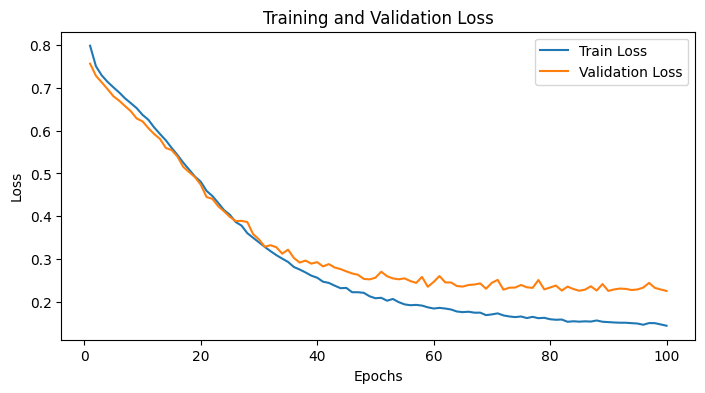

In [30]:
initial_epochs = 100
model = UNet3D(n_channels = 3, n_classes = 4, bilinear = False)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

root_dir = '/content/drive/MyDrive/Glioma_Segmentation/model'


train_model(model, train_loader, val_loader, device, num_classes = 4, num_epochs = initial_epochs, root_dir = root_dir)

Train_loss = 0.1448, Validation Loss = 0.2259, Mean IoU = 0.7026


In [38]:
def test_model(model, device, test_loader, num_classes):

  """
    Test the model on the test dataset.
    Args:
    - model: The model to test.
    - device: The device to run the test on (CPU or GPU).
    - val_loader: DataLoader for the test dataset.
    - num_classes: The number of classes in the segmentation task.

    Returns:
    - test_loss: The average test loss.
    - mean_iou: The mean Intersection over Union (IoU) score across all classes.
  """

  model.eval()
  test_losses = 0.0
  all_ious = []

  IoU_metric = IoU(num_classes)

  with torch.no_grad():
    for test_data in test_loader:
      input_x, y_true = test_data['image'].to(device), test_data['label'].to(device)
      y_pred = model(input_x)
      loss = DiceLoss()(y_true, y_pred)
      test_losses += loss.item()
      iou_score = IoU_metric(y_true, y_pred)
      all_ious.append(iou_score)

    test_losses /= len(test_loader)
    mean_iou = sum(all_ious) / len(all_ious)
  return test_losses, mean_iou

In [42]:
model = UNet3D(n_channels=3, n_classes=4)
model.load_state_dict(torch.load(os.path.join(root_dir, 'best_model_2.pth')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

test_losses, test_mean_iou = test_model(model, device, test_loader, 4)

print(f'Test Loss: {test_losses:.4f}, Test Mean IoU: {test_mean_iou:.4f}')

Test Loss: 0.2052, Test Mean IoU: 0.7333


torch.Size([4, 128, 128, 128])


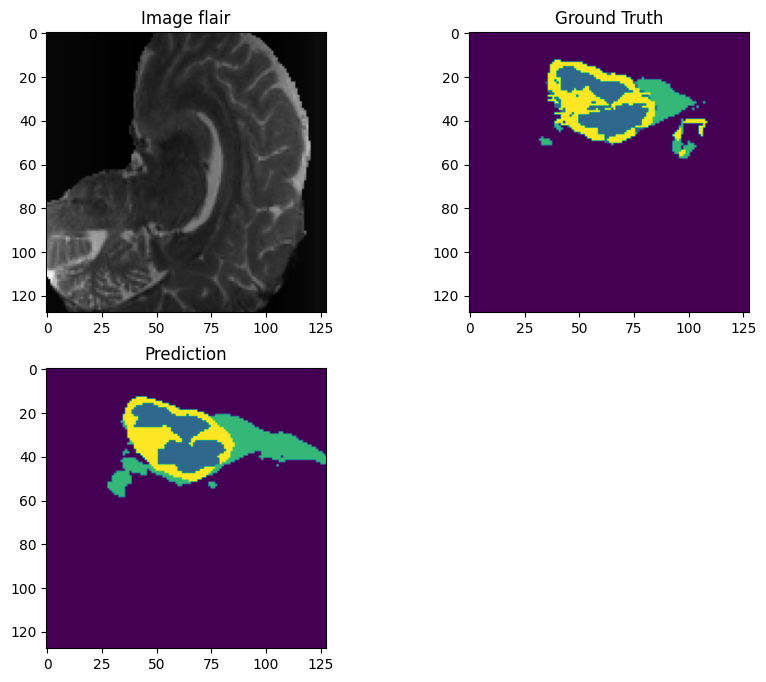

In [121]:
n_slice = 60
image_test = test_dataset[30]['image']
mask_test  = test_dataset[30]['label']
mask_test = torch.argmax(mask_test, dim = 0)

y_pred = model(image_test.to(device).unsqueeze(0))
y_pred = y_pred.squeeze(0)
print(y_pred.shape)
y_pred = torch.argmax(y_pred, dim = 0)
y_pred_cpu = y_pred.cpu()

# Display the image slices
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.imshow(image_test[2, n_slice, :, :], cmap='gray')  # Channel 0 at slice 'n_slice'
plt.title('Image flair')
plt.subplot(222)
plt.imshow(mask_test[:, :, n_slice], cmap = 'viridis')
plt.title('Ground Truth')
plt.subplot(223)
plt.imshow(y_pred_cpu[:, :, n_slice], cmap = 'viridis')
plt.title('Prediction')
plt.show()


